In [412]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
#import plotly.express as px

from pandas_profiling import ProfileReport
from sklearn import metrics
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBClassifier
from xgboost import plot_importance

In [431]:
KAGGLE_EVAL_METRIC = 'logloss' # string name for loss function in xgboost

In [432]:
TRAIN_PATH = "data/train.csv"
TEST_PATH = "data/test.csv"

# Load Data

In [433]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

# Pre-Processing

In [434]:
# NLP STUFF

In [435]:
## Helper functions
def get_nickanme(x):
    if "(" in x:
        nickname = re.findall('\(.*?\)',x)[0]
    elif '"' in x:
        nickname = re.findall('\".*?\"',x)[0]
    else:
        nickname = "none"
    return nickname

def get_lastname(name, first_name, title, nickname):
    last_name = name.replace(first_name,'')
    last_name = last_name.replace(title,'')
    last_name = last_name.replace(nickname,'')
    last_name = last_name.replace(',','')
    return last_name

def replace_last(source_string, replace_what):
    head, _sep, tail = source_string.rpartition(replace_what)
    return head + "" + tail


In [436]:
# lower case
train.Name = train.Name.str.lower()

## first name, title, nickname
train['First Name'] = train['Name'].apply(lambda x: x.split(",")[0])
train['Title'] = train['Name'].apply(lambda x: x.split(",")[1].split()[0])
train['Nickname'] = train['Name'].apply(lambda x: get_nickanme(x))
train['Last Name'] = train.apply(lambda x: get_lastname(x['Name'], x['First Name'],x['Title'],x['Nickname']), axis=1)
train['Junior'] = train['Last Name'].apply(lambda x: x.endswith(("jr","ii")))
train['Last Name'] = train['Name'].apply(lambda x: replace_last(x, "jr"))
train['Last Name'] = train['Name'].apply(lambda x: replace_last(x, "ii"))

In [437]:
# lower case
test.Name = test.Name.str.lower()

## first name, title, nickname
test['First Name'] = test['Name'].apply(lambda x: x.split(",")[0])
test['Title'] = test['Name'].apply(lambda x: x.split(",")[1].split()[0])
test['Nickname'] = test['Name'].apply(lambda x: get_nickanme(x))
test['Last Name'] = test.apply(lambda x: get_lastname(x['Name'], x['First Name'],x['Title'],x['Nickname']), axis=1)
test['Junior'] = test['Last Name'].apply(lambda x: x.endswith(("jr","ii")))
test['Last Name'] = test['Name'].apply(lambda x: replace_last(x, "jr"))
test['Last Name'] = test['Name'].apply(lambda x: replace_last(x, "ii"))

## Define Features and Target

In [438]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,First Name,Title,Nickname,Last Name,Junior
0,1,0,3,"braund, mr. owen harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,braund,mr.,none,"braund, mr. owen harris",False
1,2,1,1,"cumings, mrs. john bradley (florence briggs th...",female,38.0,1,0,PC 17599,71.2833,C85,C,cumings,mrs.,(florence briggs thayer),"cumings, mrs. john bradley (florence briggs th...",False
2,3,1,3,"heikkinen, miss. laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,heikkinen,miss.,none,"heikkinen, miss. laina",False
3,4,1,1,"futrelle, mrs. jacques heath (lily may peel)",female,35.0,1,0,113803,53.1000,C123,S,futrelle,mrs.,(lily may peel),"futrelle, mrs. jacques heath (lily may peel)",False
4,5,0,3,"allen, mr. william henry",male,35.0,0,0,373450,8.0500,NaN,S,allen,mr.,none,"allen, mr. william henry",False


In [439]:
target = train["Survived"]
categorical = ['Pclass','Name','Sex','Ticket','Cabin','Embarked','Title','Junior','Nickname']
ordinal = ['Age','SibSp','Parch','Fare']
drop_columns = ["SibSp","Parch","Name","Ticket",'Nickname']

In [440]:
def feature_selection(drop_cols, categorical_cols, ordinal_cols):
    for column in drop_cols:
        if column in categorical_cols: categorical_cols.remove(column)
        if column in ordinal_cols: ordinal_cols.remove(column)
    features = categorical_cols + ordinal_cols
    return features

In [441]:
features = feature_selection(drop_columns,categorical,ordinal)

In [442]:
train = train[features] 
test = test[features]

---

Combine train + test to ensure they receive the same preproccessing (category indexs)

In [443]:
train['label'] = 'train'
test['label'] = 'test'

to_clean = train.append(test)

---

## NULLS
To start we'll use XGBOOST and let the algo deal with nulll.
- Age: 
- SibSpa
- Parch
- Fare:
- Embark: 

Future iterations, we can improve score by doing a better job with our NULL values.

In [444]:
#train = train.fillna(-1)
#test = test.fillna(-1)

--- 

## Categorical Data
Transform categorical features to integer representatins

In [445]:
# categorical encoding
def objects_to_category(df):
    '''
    function that converts objects to categorical features.
    '''
    object_cols = df.columns.tolist()
    object_features = df[object_cols].astype("category")
    for field in object_cols:
        df[field] = object_features[field].cat.codes
    return df

to_clean[categorical] = objects_to_category(to_clean[categorical])
to_clean[categorical] = objects_to_category(to_clean[categorical])

<ipython-input-445-e4c6efef39e0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[field] = object_features[field].cat.codes


In [446]:
to_clean.head()

,Pclass,Sex,Cabin,Embarked,Title,Junior,Age,Fare,label
0,2,1,0,3,12,0,22.0,7.2500,train
1,0,0,107,1,13,0,38.0,71.2833,train
2,2,0,0,3,9,0,26.0,7.9250,train
3,0,0,71,3,13,0,35.0,53.1000,train
4,2,1,0,3,12,0,35.0,8.0500,train


---

## Done

In [447]:
train = to_clean[to_clean['label'] == 'train'].drop('label',axis=1)
test = to_clean[to_clean['label'] == 'test'].drop('label',axis=1)

Drop features that we don't want to use

In [448]:
print(features)

['Pclass', 'Sex', 'Cabin', 'Embarked', 'Title', 'Junior', 'Age', 'Fare']


# Modeling

In [449]:
X = train[features]
y = target

In [450]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=40)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

In [451]:
#View notbook for details on  Parameter Tuning
clf = XGBClassifier(max_depth=4,
                    min_child_weight=1,
                    learning_rate=0.05,
                    n_estimators=100,
                    silent=True,
                    objective='binary:logistic',
                    #gamma=4,
                    #max_delta_step=0,
                    #subsample=0.88,
                    #colsample_bytree=1,
                    #colsample_bylevel=1,
                    #reg_alpha=0,
                    #reg_lambda=0,
                    #scale_pos_weight=1,
                    #seed=1,
                    #missing=None,
                    #enable_categorical=True
                    )

clf.fit(
    X_train,
    y_train,
    eval_metric=KAGGLE_EVAL_METRIC,
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=False,
    early_stopping_rounds = 10
)

[15:29:05] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/neil/anaconda3/envs/ds_py_3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=True,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

Guess Everyone Survived
0.45555555555555555
---
Model Predicitons


/home/neil/anaconda3/envs/ds_py_3.8/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


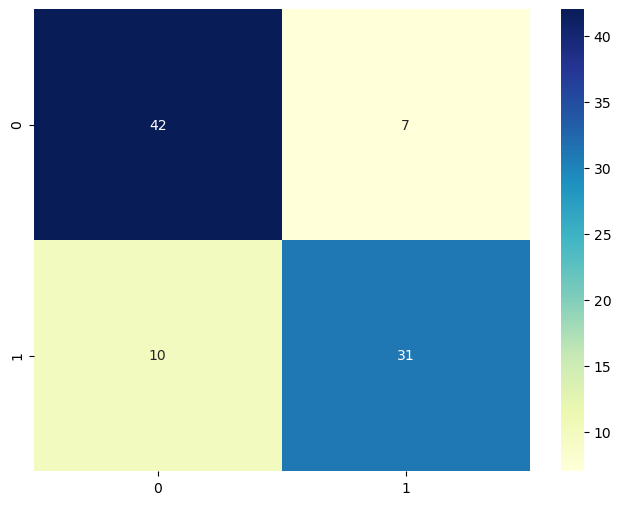

0.4129093777388334
0.8111111111111111


In [452]:
# riding style null fixed
## Create Report
y_pred = clf.predict(X_test)
probs = clf.predict_proba(X_test)

results = pd.DataFrame(y_test)
#temp = pd.DataFrame(probs)
results['actual_classification'] = y_test
results['predicted_classification'] = y_pred
results['baseline_classification'] = 1
results['buy_prob_28'] = probs[:,1]

# baseline
print("Guess Everyone Survived")
print(metrics.accuracy_score(results['actual_classification'], results['baseline_classification']))
print("---")
print("Model Predicitons")

plt.rcParams["figure.figsize"] = (8, 6)
matrix = metrics.confusion_matrix(results['actual_classification'], results['predicted_classification'])
sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.show()

#classification summary stats
print(metrics.log_loss(results['actual_classification'],results['buy_prob_28']))
print(metrics.accuracy_score(results['actual_classification'], results['predicted_classification']))
#print(metrics.roc_auc_score(results['actual_classification'],results['buy_prob_28']))
#print(metrics.brier_score_loss(results['actual_classification'],results['buy_prob_28']))
#print(metrics.f1_score(results['actual_classification'], results['predicted_classification']))
#print(metrics.recall_score(results['actual_classification'], results['predicted_classification']))
#print(metrics.precision_score(results['actual_classification'], results['predicted_classification']))
#print(metrics.average_precision_score(results['actual_classification'], results['predicted_classification']))

In [453]:
## dropping everything made it worst...
## Seems like with xgboost, the best thing to do is to get into feature engineering as fast as possible...

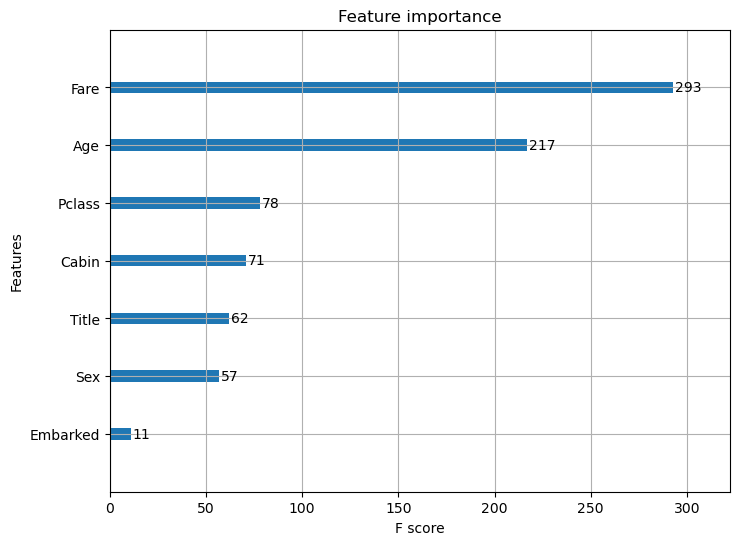

In [454]:
plot_importance(clf)
plt.show()

In [259]:
## I would assume "NAME", "TICK", are over fitting...

## Neil's Custome Pipeline

In [249]:
#load_data()

#target = train["Survived"]
#categorical = ['Pclass','Name','Sex','Ticket','Cabin','Embarked']
#ordinal = ['Age','SibSp','Parch','Fare']
#drop_columns = ["SibSp","Cabin","Ticket","Parch"]

#define features
#features = feature_selection(cols_to_drop, cat_cols, num_cols)
#train = train[features] 
#test = test[features]